### Ejecuciones en la terminal

In [ ]:
#cd "enfermedades_cardiacas_grupo_1"
# Ejecutar en la terminal



In [ ]:
import json
import os
with open("credentials.json") as f:
    os.environ["GDRIVE_CREDENTIALS_DATA"] = f.read()



drive_id = "1VpJLIEIIely_NcvUVKy0F5IXGUkr3e_S" # id carpeta
os.environ["DRIVEID"] = drive_id

In [ ]:
# dvc init
# dvc remote add -d storage gdrive://1VpJLIEIIely_NcvUVKy0F5IXGUkr3e_S
# dvc remote modify storage gdrive_service_account_json_file_path "c:\\Users\\rosme\\OneDrive\\Documentos\\UNAL\\credentials.json"
# dvc pull

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.2 MB/s eta 0:00:00


Creamos una función auxiliar para guardar las métricas principales de desempeño de cada modelo para a la final poder compararlos todos. Quedaran guardadas en el dataframe llamado "EVALUACION_DATAFRAME"

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def agregar_modelo(df=None, modelo=None, descripcion_modelo=None, y_test=None, y_pred=None):
    # Si no se proporciona un DataFrame, crear uno vacío
    if df is None:
        df = pd.DataFrame(columns=['modelo', 'descripcion_modelo', 'hiperparametros', 'accuracy', 'precision', 'recall', 'f1-score'])

    # Definir los valores para cada columna del DataFrame
    hiperparametros = modelo.best_params_
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

    # Crear un diccionario con los valores del nuevo registro
    nuevo_registro = {
        'modelo': [modelo.best_estimator_.steps[-1][0]],
        'descripcion_modelo': [descripcion_modelo],
        'hiperparametros': [hiperparametros],
        'accuracy': [accuracy],
        'precision': [precision],
        'recall': [recall],
        'f1-score': [f1_score]
    }

    # Convertir el diccionario en DataFrame
    nuevo_df = pd.DataFrame(nuevo_registro)

    # Concatenar el nuevo DataFrame al DataFrame existente
    df_nuevo = pd.concat([df, nuevo_df], ignore_index=True)

    return df_nuevo


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
df_heart_2022_no_nans = pd.read_csv("heart_2022_no_nans.csv")

In [ ]:
X = df_heart_2022_no_nans.drop('HadHeartAttack', axis=1)
#X = pd.get_dummies(X)
y = df_heart_2022_no_nans['HadHeartAttack']

In [ ]:
categoricas = X.select_dtypes(include='object').columns.tolist()

# Obtener los nombres de las variables numéricas
numericas = X.select_dtypes(exclude='object').columns.tolist()


In [ ]:
tf = ColumnTransformer([
        ('onehot', OneHotEncoder(), categoricas),
        ('scaler', StandardScaler(), numericas)])
X = tf.fit_transform(X)

In [ ]:
## Partición de los datos originales
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [ ]:
# Aplicar sobremuestreo
oversample = RandomOverSampler(sampling_strategy='minority')
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train_O, X_test_O, y_train_O, y_test_O = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1234)

In [ ]:
# Aplicar submuestreo
undersample = RandomUnderSampler(sampling_strategy='majority')
X_resampled, y_resampled = undersample.fit_resample(X, y)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train_U, X_test_U, y_train_U, y_test_U = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1234)

## **1. Selección y diseño de modelos**
---

Probaremos diversos modelos de clasificiación debido a que tenemos una variable a predecir que es: una persona tendrá ataque cardiaco o no (HadHeartAttack)

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from joblib import dump, load

In [ ]:
ruta_guardado = "/content/drive/Shareddrives/2. Introducción a Machine Learning con Python/Entrega 4/Modelos guardados"

### 1.1 modelo : LOGISTIC REGRESION


In [ ]:
from sklearn.linear_model import LogisticRegression
# Crear un pipeline con Regresión Logística
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # Escalar las características
    ('lr', LogisticRegression(random_state=42))  # Clasificador Regresión Logística
])

# Definir la grilla de hiperparámetros específicos de Regresión Logística
param_grid = {
    'lr__C': [0.1, 1, 10],  # Inverso de la fuerza de regularización
    'lr__penalty': ['l1', 'l2']  # Tipo de regularización (L1 o L2)
}

grid_search_LogisticRegression = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=10)
grid_search_LogisticRegression.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(grid_search_LogisticRegression.best_params_)

# Predecir en el conjunto de prueba
y_pred = grid_search_LogisticRegression.predict(X_test)

# Mostrar métricas de evaluación
print("Informe de clasificación:")
Ligistic_regression_report=classification_report(y_test, y_pred)
print(Ligistic_regression_report)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
 

Mejores hiperparámetros:
{'lr__C': 1, 'lr__penalty': 'l2'}
Informe de clasificación:
              precision    recall  f1-score   support

          No       0.96      0.99      0.97     46513
         Yes       0.58      0.25      0.35      2692

    accuracy                           0.95     49205
   macro avg       0.77      0.62      0.66     49205
weighted avg       0.94      0.95      0.94     49205



In [ ]:
# Guardar el modelo
# Guardar el mejor modelo de Regresión Logística
best_model = grid_search.best_estimator_
dump(best_model, ruta_guardado + "/reg_logistica.joblib")

['/content/drive/Shareddrives/2. Introducción a Machine Learning con Python/Entrega 4/Modelos guardados/reg_logistica.joblib']

In [ ]:
# Prueba de carga del modelo guardado

# Cargar el modelo guardado
#best_model = load(ruta_guardado + "/reg_logistica.joblib")

# Usar el modelo cargado para predecir
#y_pred_loaded = loaded_model.predict(X_test)

In [ ]:
EVALUACION_DATAFRAME=agregar_modelo(None, grid_search,"logistic regresion  datos originales",y_test, y_pred)

### 1.2  modelo : SMV


In [ ]:
from sklearn.svm import SVC
# Crear un pipeline con SVM
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # Escalar las características
    ('svc', SVC(random_state=42))  # Clasificador SVM
])

# Definir la grilla de hiperparámetros específicos de SVM
param_grid = {
    'svc__C': [1],  # Parámetro de regularización
    'svc__kernel': ['rbf']  # Tipo de kernel
}

# Crear un objeto GridSearchCV
svm_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=3)

# Entrenar el modelo utilizando GridSearchCV
svm_search.fit(X_train_U, y_train_U)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(svm_search.best_params_)



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Mejores hiperparámetros:
{'svc__C': 1, 'svc__kernel': 'rbf'}
Informe de clasificación:
              precision    recall  f1-score   support

          No       0.79      0.85      0.82      2686
         Yes       0.83      0.77      0.80      2688

    accuracy                           0.81      5374
   macro avg       0.81      0.81      0.81      5374
weighted avg       0.81      0.81      0.81      5374



In [ ]:
# Predecir en el conjunto de prueba
y_pred = svm_search.predict(X_test)

# Mostrar métricas de evaluación
print("Informe de clasificación:")
svm_report = classification_report(y_test, y_pred)
print(svm_report)


Informe de clasificación:
              precision    recall  f1-score   support

          No       0.99      0.84      0.91     46513
         Yes       0.23      0.82      0.35      2692

    accuracy                           0.84     49205
   macro avg       0.61      0.83      0.63     49205
weighted avg       0.95      0.84      0.88     49205



In [ ]:
EVALUACION_DATAFRAME=agregar_modelo(EVALUACION_DATAFRAME, svm_search,"Modelo SMv  datos originales",y_test_U, y_pred)

In [ ]:
EVALUACION_DATAFRAME.to_excel("Archivo V.xlsx",index=False)

In [ ]:
EVALUACION_DATAFRAME

### 1.3: Modelo Random Forest

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

def plot_best_tree(grid_search):
    # Extraer el mejor modelo del GridSearchCV
    best_model = grid_search.best_estimator_

    # Si el mejor modelo es un RandomForestClassifier
    if 'rf' in best_model.named_steps:
        # Extraer un árbol del bosque (por ejemplo, el primero)
        primer_arbol = best_model['rf'].estimators_[0]

        # Plotear el árbol
        plt.figure(figsize=(20, 10))
        plot_tree(primer_arbol, feature_names=X_train.columns, class_names=["Clase 0", "Clase 1"], filled=True)
        plt.show()
    else:
        print("El mejor modelo no es un RandomForestClassifier. No se puede visualizar un árbol.")


#### 1.3.1: Modelo Random Forest con los datos originales

In [ ]:
# Crear un pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # Escalar las características
    ('rf', RandomForestClassifier(random_state=42))  # Clasificador Random Forest
])

# Definir la grilla de hiperparámetros
param_grid = {
    'rf__n_estimators': [10, 20],  # Número de árboles en el bosque
    'rf__max_depth': [2, 5, 10],  # Profundidad máxima de los árboles
    'rf__min_samples_split': [2, 5],  # Número mínimo de muestras requeridas para dividir un nodo
    'rf__min_samples_leaf': [1, 2]  # Número mínimo de muestras requeridas en cada nodo hoja
}

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=10)

# Entrenar el modelo utilizando GridSearchCV
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(grid_search.best_params_)

# Predecir en el conjunto de prueba
y_pred = grid_search.predict(X_test)

# Mostrar métricas de evaluación
print("Informe de clasificación:")
Random_forest_report = classification_report(y_test, y_pred)
print(Random_forest_report)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores hiperparámetros:
{'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 20}
Informe de clasificación:
              precision    recall  f1-score   support

          No       0.95      1.00      0.97     46513
         Yes       0.64      0.09      0.16      2692

    accuracy                           0.95     49205
   macro avg       0.80      0.55      0.57     49205
weighted avg       0.93      0.95      0.93     49205



In [ ]:
# Guardar el mejor modelo de Regresión Logística
best_model = grid_search.best_estimator_
dump(best_model, ruta_guardado + "/random_forest.joblib")

['/content/drive/Shareddrives/2. Introducción a Machine Learning con Python/Entrega 4/Modelos guardados/random_forest.joblib']

In [ ]:
# Cargar el modelo guardado
#loaded_model = load(ruta_guardado + "/random_forest.joblib")

# Usar el modelo cargado para predecir
#y_pred_loaded = loaded_model.predict(X_test)

In [ ]:
EVALUACION_DATAFRAME=agregar_modelo(EVALUACION_DATAFRAME, grid_search,"Random Forest  datos originales",y_test, y_pred)

In [ ]:
EVALUACION_DATAFRAME

,modelo,descripcion_modelo,hiperparametros,accuracy,precision,recall,f1-score
0,rf,Random Forest datos originales,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.947546,0.933097,0.947546,0.928663


In [ ]:
EVALUACION_DATAFRAME=agregar_modelo(EVALUACION_DATAFRAME, grid_search,"Random Forest  datos originales",y_test, y_pred)

#### 1.3.2: Modelo Random Forest con sobremuestreo (Oversampling)

In [ ]:
# Entrenar el modelo utilizando GridSearchCV
grid_search.fit(X_train_O, y_train_O)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores hiperparámetros:
{'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 20}


In [ ]:
# Predecir en el conjunto de prueba
y_pred = grid_search.predict(X_test_O)

# Mostrar métricas de evaluación
print("Informe de clasificación:")
print(classification_report(y_test_O, y_pred))

Informe de clasificación:
              precision    recall  f1-score   support

          No       0.80      0.84      0.82     46455
         Yes       0.83      0.79      0.81     46580

    accuracy                           0.81     93035
   macro avg       0.81      0.81      0.81     93035
weighted avg       0.81      0.81      0.81     93035



In [ ]:
EVALUACION_DATAFRAME=agregar_modelo(EVALUACION_DATAFRAME, grid_search,"Random Forest  Sobre muestreo",y_test_O, y_pred)

In [ ]:
plot_best_tree(grid_search)

#### 1.3.3: Modelo Random Forest con submuestreo (Undersampling)

In [ ]:
# Entrenar el modelo utilizando GridSearchCV
grid_search.fit(X_train_U, y_train_U)

# Se muestran los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores hiperparámetros:
{'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 20}


In [ ]:
best_model = grid_search.best_estimator_
dump(best_model, ruta_guardado + "/random_forest_us.joblib")

['/content/drive/Shareddrives/2. Introducción a Machine Learning con Python/Entrega 4/Modelos guardados/random_forest_us.joblib']

In [ ]:
# Predecir en el conjunto de prueba
y_pred = grid_search.predict(X_test_U)

# Mostrar métricas de evaluación
print("Informe de clasificación:")
print(classification_report(y_test_U, y_pred))

Informe de clasificación:
              precision    recall  f1-score   support

          No       0.78      0.81      0.80      2686
         Yes       0.81      0.77      0.79      2688

    accuracy                           0.79      5374
   macro avg       0.79      0.79      0.79      5374
weighted avg       0.79      0.79      0.79      5374



In [ ]:
EVALUACION_DATAFRAME=agregar_modelo(EVALUACION_DATAFRAME, grid_search,"Random Forest  Sub muestreo",y_test_U, y_pred)

### 1.4: XGBoost

#### 1.4.1: XGBoost: Datos originales

In [ ]:
from xgboost import XGBClassifier

y_train_binary = y_train.map({'No': 0, 'Yes': 1})
y_test_binary = y_test.map({'No': 0, 'Yes': 1})

# Crear un pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # Escalar las características
    ('xgb', XGBClassifier(random_state=42, objective='binary:logistic'))  # Clasificador XGBoost
])

# Definir la grilla de hiperparámetros
param_grid = {
    'xgb__n_estimators': [10, 20],  # Número de árboles
    'xgb__max_depth': [2, 5, 10],  # Profundidad máxima de los árboles
    'xgb__learning_rate': [0.05, 0.01],  # Tasa de aprendizaje
    'xgb__min_child_weight': [1, 2],  # Peso mínimo de las hojas
    #'xgb__subsample': [0.8, 1.0],  # Submuestra de observaciones
    #'xgb__colsample_bytree': [0.8, 1.0],  # Submuestra de características
    'xgb__gamma': [0, 1]  # Regularización gamma
}

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=10)

# Entrenar el modelo utilizando GridSearchCV
grid_search.fit(X_train, y_train_binary)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      imp...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgb__gamma': [0, 1],
                         'xgb__learning_rate': [0.05, 0.01],
                         'xgb__max_depth': [2, 5, 10],
                         'xgb__min_child_weight': [1, 2],
                         'xgb__n_estimators': [10, 20]},
             verbose=10)

In [ ]:
# Se muestran los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(grid_search.best_params_)

Mejores hiperparámetros:
{'xgb__gamma': 1, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 10, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 20}


In [ ]:
best_model = grid_search.best_estimator_
dump(best_model, ruta_guardado + "/xgboost.joblib")

['/content/drive/Shareddrives/2. Introducción a Machine Learning con Python/Entrega 4/Modelos guardados/xgboost.joblib']

In [ ]:
# Predecir en el conjunto de prueba
y_pred = grid_search.predict(X_test)

# Mostrar métricas de evaluación
print("Informe de clasificación:")
print(classification_report(y_test_binary, y_pred))

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     46513
           1       0.70      0.03      0.06      2692

    accuracy                           0.95     49205
   macro avg       0.82      0.51      0.51     49205
weighted avg       0.93      0.95      0.92     49205



In [ ]:
EVALUACION_DATAFRAME=agregar_modelo(EVALUACION_DATAFRAME, grid_search,"XGBoost Datos Originales",y_test_binary, y_pred)

#### 1.4.2: XGboost con Sobremuestreo

In [ ]:
y_train_binary = y_train_O.map({'No': 0, 'Yes': 1})
y_test_binary = y_test_O.map({'No': 0, 'Yes': 1})

# Crear un pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # Escalar las características
    ('xgb', XGBClassifier(random_state=42, objective='binary:logistic'))  # Clasificador XGBoost
])

# Definir la grilla de hiperparámetros
param_grid = {
    'xgb__n_estimators': [10, 20],  # Número de árboles
    'xgb__max_depth': [2, 5, 10],  # Profundidad máxima de los árboles
    'xgb__learning_rate': [0.05, 0.01],  # Tasa de aprendizaje
    'xgb__min_child_weight': [1, 2],  # Peso mínimo de las hojas
    #'xgb__subsample': [0.8, 1.0],  # Submuestra de observaciones
    #'xgb__colsample_bytree': [0.8, 1.0],  # Submuestra de características
    'xgb__gamma': [0, 1]  # Regularización gamma
}

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=10)

# Entrenar el modelo utilizando GridSearchCV
grid_search.fit(X_train_O, y_train_binary)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      imp...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgb__gamma': [0, 1],
                         'xgb__learning_rate': [0.05, 0.01],
                         'xgb__max_depth': [2, 5, 10],
                         'xgb__min_child_weight': [1, 2],
                         'xgb__n_estimators': [10, 20]},
             verbose=10)

In [ ]:
# Predecir en el conjunto de prueba
y_pred = grid_search.predict(X_test_O)

# Mostrar métricas de evaluación
print("Informe de clasificación:")
print(classification_report(y_test_binary, y_pred))

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83     46455
           1       0.84      0.81      0.83     46580

    accuracy                           0.83     93035
   macro avg       0.83      0.83      0.83     93035
weighted avg       0.83      0.83      0.83     93035



In [ ]:
EVALUACION_DATAFRAME=agregar_modelo(EVALUACION_DATAFRAME, grid_search,"XGBoost Sobremuestreo",y_test_binary, y_pred)

#### 1.4.3: XGboost submustreo

In [ ]:
y_train_binary = y_train_U.map({'No': 0, 'Yes': 1})
y_test_binary = y_test_U.map({'No': 0, 'Yes': 1})

# Crear un pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # Escalar las características
    ('xgb', XGBClassifier(random_state=42, objective='binary:logistic'))  # Clasificador XGBoost
])

# Definir la grilla de hiperparámetros
param_grid = {
    'xgb__n_estimators': [10, 20],  # Número de árboles
    'xgb__max_depth': [2, 5, 10],  # Profundidad máxima de los árboles
    'xgb__learning_rate': [0.05, 0.01],  # Tasa de aprendizaje
    'xgb__min_child_weight': [1, 2],  # Peso mínimo de las hojas
    #'xgb__subsample': [0.8, 1.0],  # Submuestra de observaciones
    #'xgb__colsample_bytree': [0.8, 1.0],  # Submuestra de características
    'xgb__gamma': [0, 1]  # Regularización gamma
}

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=10)

# Entrenar el modelo utilizando GridSearchCV
grid_search.fit(X_train_U, y_train_binary)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      imp...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgb__gamma': [0, 1],
                         'xgb__learning_rate': [0.05, 0.01],
                         'xgb__max_depth': [2, 5, 10],
                         'xgb__min_child_weight': [1, 2],
                         'xgb__n_estimators': [10, 20]},
             verbose=10)

In [ ]:
best_model = grid_search.best_estimator_
dump(best_model, ruta_guardado + "/xgboosts_us.joblib")

['/content/drive/Shareddrives/2. Introducción a Machine Learning con Python/Entrega 4/Modelos guardados/xgboosts_us.joblib']

In [ ]:
# Predecir en el conjunto de prueba
y_pred = grid_search.predict(X_test_U)

# Mostrar métricas de evaluación
print("Informe de clasificación:")
print(classification_report(y_test_binary, y_pred))

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      2686
           1       0.83      0.72      0.77      2688

    accuracy                           0.79      5374
   macro avg       0.79      0.79      0.79      5374
weighted avg       0.79      0.79      0.79      5374



In [ ]:
EVALUACION_DATAFRAME=agregar_modelo(EVALUACION_DATAFRAME, grid_search,"XGBoost Submuestreo",y_test_binary, y_pred)

### 1.5: Catboost

#### 1.5.1: Catboost datos originales

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
# Map 'No' to 0 and 'Yes' to 1 in the target variable y
y_train_binary = y_train.map({'No': 0, 'Yes': 1})
y_test_binary = y_test.map({'No': 0, 'Yes': 1})

# Create a pipeline with CatBoost
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # Scale features
    ('catboost', CatBoostClassifier(random_state=42, verbose=0))  # CatBoost classifier
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'catboost__n_estimators': [10, 20],
    'catboost__depth': [4, 6, 8],
    'catboost__learning_rate': [0.01, 0.05], # Quitaré el learning rate de 0.1, es muy alto...
    'catboost__l2_leaf_reg': [1, 3, 5, 7]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=10)

# Train the model using GridSearchCV
grid_search.fit(X_train, y_train_binary)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('catboost',
                                        <catboost.core.CatBoostClassifier object at 0x78fe18c13700>)]),
             n_jobs=-1,
             param_grid={'catboost__depth': [4, 6, 8],
                         'catboost__l2_leaf_reg': [1, 3, 5, 7],
                         'catboost__learning_rate': [0.01, 0.05],
                         'catboost__n_estimators': [10, 20]},
             verbose=10)

In [ ]:
best_model = grid_search.best_estimator_
dump(best_model, ruta_guardado + "/catboost.joblib")

['/content/drive/Shareddrives/2. Introducción a Machine Learning con Python/Entrega 4/Modelos guardados/catboost.joblib']

In [ ]:
# Predecir en el conjunto de prueba
y_pred = grid_search.predict(X_test)

# Mostrar métricas de evaluación
print("Informe de clasificación:")
print(classification_report(y_test_binary, y_pred))

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     46513
           1       0.61      0.19      0.29      2692

    accuracy                           0.95     49205
   macro avg       0.78      0.59      0.63     49205
weighted avg       0.94      0.95      0.94     49205



In [ ]:
EVALUACION_DATAFRAME=agregar_modelo(EVALUACION_DATAFRAME, grid_search,"Catboost Datos originales",y_test_binary, y_pred)

#### 1.5.3: Catboost sobremuestreo

In [ ]:
# Map 'No' to 0 and 'Yes' to 1 in the target variable y
y_train_binary = y_train_U.map({'No': 0, 'Yes': 1})
y_test_binary = y_test_U.map({'No': 0, 'Yes': 1})

# Create a pipeline with CatBoost
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # Scale features
    ('catboost', CatBoostClassifier(random_state=42, verbose=0))  # CatBoost classifier
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'catboost__n_estimators': [10, 20],
    'catboost__depth': [4, 6, 8],
    'catboost__learning_rate': [0.01, 0.05], # Quitaré el learning rate de 0.1, es muy alto...
    'catboost__l2_leaf_reg': [1, 3, 5, 7]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=10)

# Train the model using GridSearchCV
grid_search.fit(X_train_U, y_train_binary)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('catboost',
                                        <catboost.core.CatBoostClassifier object at 0x78fe18c132b0>)]),
             n_jobs=-1,
             param_grid={'catboost__depth': [4, 6, 8],
                         'catboost__l2_leaf_reg': [1, 3, 5, 7],
                         'catboost__learning_rate': [0.01, 0.05],
                         'catboost__n_estimators': [10, 20]},
             verbose=10)

In [ ]:
best_model = grid_search.best_estimator_
dump(best_model, ruta_guardado + "/catboost_us.joblib")

['/content/drive/Shareddrives/2. Introducción a Machine Learning con Python/Entrega 4/Modelos guardados/catboost_us.joblib']

In [ ]:
# Predecir en el conjunto de prueba
y_pred = grid_search.predict(X_test_U)

# Mostrar métricas de evaluación
print("Informe de clasificación:")
print(classification_report(y_test_binary, y_pred))

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81     46455
           1       0.83      0.77      0.80     46580

    accuracy                           0.80     93035
   macro avg       0.81      0.80      0.80     93035
weighted avg       0.81      0.80      0.80     93035



In [ ]:
EVALUACION_DATAFRAME=agregar_modelo(EVALUACION_DATAFRAME, grid_search,"Catboost Sobre muestreo",y_test_binary, y_pred)

#### 1.5.3: Catboost submuestreo

In [ ]:
# Map 'No' to 0 and 'Yes' to 1 in the target variable y
y_train_binary = y_train_U.map({'No': 0, 'Yes': 1})
y_test_binary = y_test_U.map({'No': 0, 'Yes': 1})

# Create a pipeline with CatBoost
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # Scale features
    ('catboost', CatBoostClassifier(random_state=42, verbose=0))  # CatBoost classifier
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'catboost__n_estimators': [10, 20],
    'catboost__depth': [4, 6, 8],
    'catboost__learning_rate': [0.01, 0.05], # Quitaré el learning rate de 0.1, es muy alto...
    'catboost__l2_leaf_reg': [1, 3, 5, 7]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=10)

# Train the model using GridSearchCV
grid_search.fit(X_train_U, y_train_binary)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('catboost',
                                        <catboost.core.CatBoostClassifier object at 0x7ba745b2fd60>)]),
             n_jobs=-1,
             param_grid={'catboost__depth': [4, 6, 8],
                         'catboost__l2_leaf_reg': [1, 3, 5, 7],
                         'catboost__learning_rate': [0.01, 0.05],
                         'catboost__n_estimators': [10, 20]},
             verbose=10)

In [ ]:
# Predecir en el conjunto de prueba
y_pred = grid_search.predict(X_test_U)

# Mostrar métricas de evaluación
print("Informe de clasificación:")
print(classification_report(y_test_binary, y_pred))

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.77      0.85      0.80      2686
           1       0.83      0.74      0.78      2688

    accuracy                           0.79      5374
   macro avg       0.80      0.79      0.79      5374
weighted avg       0.80      0.79      0.79      5374



In [ ]:
EVALUACION_DATAFRAME=agregar_modelo(EVALUACION_DATAFRAME, grid_search,"Catboost Sub Muestreo",y_test_binary, y_pred)

### 1.7: Redes neuronales

In [ ]:
# Clasificador basado en una red neuronal multicapa.
from sklearn.neural_network import MLPClassifier

#### 1.7.1: Redes neuronales con los datos originales

In [ ]:
rn_pipeline = Pipeline([
    ('rn', MLPClassifier(random_state=42, max_iter=1000))  # Clasificador Regresión Logística
])

# Definir la grilla de hiperparámetros específicos de Regresión Logística
rn_param_grid = {
    'rn__solver': ['sgd'],#,'adam'],
    'rn__activation': ['relu'],#, 'tanh', 'logistic'],
    'rn__hidden_layer_sizes': [(20, 20)]#, (20,), (50,)],
}

# Crear un objeto GridSearchCV
rn_grid_search = GridSearchCV(rn_pipeline, rn_param_grid, cv=3, n_jobs=-1, verbose=1)

# Entrenar el modelo utilizando GridSearchCV
rn_grid_search.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = rn_grid_search.predict(X_test)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(rn_grid_search.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Mejores hiperparámetros:
{'rn__activation': 'relu', 'rn__hidden_layer_sizes': (20, 20), 'rn__solver': 'sgd'}


In [ ]:
EVALUACION_DATAFRAME=agregar_modelo(EVALUACION_DATAFRAME, rn_grid_search,"Redes neuronales - datos originales",y_test, y_pred)

#### 1.7.3: Redes neuronales con submuestreo (Undersampling)

In [ ]:
# Definir la grilla de hiperparámetros específicos de Regresión Logística
rn_param_grid = {
    'rn__solver': ['sgd'],#,'adam'],
    'rn__activation': ['tanh'],#, 'relu', 'logistic'],
    'rn__hidden_layer_sizes': [(50,)]#, (20,), (20, 20)],
}

# Crear un objeto GridSearchCV
rn_grid_search = GridSearchCV(rn_pipeline, rn_param_grid, cv=3, n_jobs=-1, verbose=1)

# Entrenar el modelo utilizando GridSearchCV
rn_grid_search.fit(X_train_U, y_train_U)

# Predecir en el conjunto de prueba
y_pred = rn_grid_search.predict(X_test_U)

# Se muestran los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(rn_grid_search.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Mejores hiperparámetros:
{'rn__activation': 'tanh', 'rn__hidden_layer_sizes': (50,), 'rn__solver': 'sgd'}


In [ ]:
EVALUACION_DATAFRAME=agregar_modelo(EVALUACION_DATAFRAME, rn_grid_search,"Redes neuronales - Sub muestreo",y_test_U, y_pred)

In [ ]:
EVALUACION_DATAFRAME.to_excel('EVALUACION_DATAFRAME.xlsx', index=False)

### 1.8: Detección de anomalías

In [ ]:
#Importamos librerias necesarias
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import make_blobs, make_moons
from sklearn.ensemble import IsolationForest
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline

#### 1.8.1: Robust covariance

In [ ]:
robust_covariance = EllipticEnvelope(contamination=0.05, random_state=42)

In [ ]:
y_pred = robust_covariance.fit(X_train.toarray()).predict(X_train.toarray())

/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


In [ ]:
mapeo = {-1: "Yes", 1: "No"}
y_pred_mapeado = np.array([mapeo[x] for x in y_pred], dtype=object)

In [ ]:
accuracy = accuracy_score(y_train.values, y_pred_mapeado)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train.values, y_pred_mapeado, average='macro')
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1_score: {f1_score}')

accuracy: 0.9115320322939583
precision: 0.5560941417950688
recall: 0.5516334726681897
f1_score: 0.5537127817859242


In [ ]:
y_pred_test = robust_covariance.predict(X_test.toarray())
y_pred_test_mapeado = np.array([mapeo[x] for x in y_pred_test], dtype=object)

accuracy = accuracy_score(y_test.values, y_pred_test_mapeado)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test.values, y_pred_test_mapeado, average='macro')
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1_score: {f1_score}')

accuracy: 0.9147850828167869
precision: 0.56891702457178
recall: 0.5615584343976563
f1_score: 0.5649208302046823


In [ ]:
nuevo_registro = {
    'modelo': ['anomalías'],
    'descripcion_modelo': ['Robust covariance'],
    'hiperparametros': ['contamination=0.05'],
    'accuracy': [accuracy],
    'precision': [precision],
    'recall': [recall],
    'f1-score': [f1_score]
}

# Convertir el diccionario en DataFrame
nuevo_df = pd.DataFrame(nuevo_registro)

# Concatenar el nuevo DataFrame al DataFrame existente
EVALUACION_DATAFRAME = pd.concat([EVALUACION_DATAFRAME, nuevo_df], ignore_index=True)

#### 1.8.2: Isolation Forest

In [ ]:
 isolation_forest = IsolationForest(contamination=0.05, random_state=42)

In [ ]:
y_pred = isolation_forest.fit(X_train.toarray()).predict(X_train.toarray())

In [ ]:
mapeo = {-1: "Yes", 1: "No"}
y_pred_mapeado = np.array([mapeo[x] for x in y_pred], dtype=object)

In [ ]:
accuracy = accuracy_score(y_train.values, y_pred_mapeado)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train.values, y_pred_mapeado, average='macro')
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1_score: {f1_score}')

accuracy: 0.9172937297083077
precision: 0.9139239888561842
recall: 0.9172937297083077
f1_score: 0.9155816050162573


In [ ]:
y_pred_test = isolation_forest.predict(X_test.toarray())
y_pred_test_mapeado = np.array([mapeo[x] for x in y_pred_test], dtype=object)

accuracy = accuracy_score(y_test.values, y_pred_test_mapeado)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test.values, y_pred_test_mapeado, average='macro')
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1_score: {f1_score}')

accuracy: 0.9181587237069404
precision: 0.9152668016905006
recall: 0.9181587237069404
f1_score: 0.9166910496995853


In [ ]:
nuevo_registro = {
    'modelo': ['anomalías'],
    'descripcion_modelo': ['Isolation Forest'],
    'hiperparametros': ['contamination=0.05'],
    'accuracy': [accuracy],
    'precision': [precision],
    'recall': [recall],
    'f1-score': [f1_score]
}

# Convertir el diccionario en DataFrame
nuevo_df = pd.DataFrame(nuevo_registro)

# Concatenar el nuevo DataFrame al DataFrame existente
EVALUACION_DATAFRAME = pd.concat([EVALUACION_DATAFRAME, nuevo_df], ignore_index=True)

#### 1.8.3: Local Outlier Factor

In [ ]:
 local_outlier_factor = LocalOutlierFactor(n_neighbors=35, contamination=0.05, novelty=True)

In [ ]:
local_outlier_factor.fit(X_train.toarray())
y_pred = local_outlier_factor.predict(X_train.toarray())

In [ ]:
mapeo = {-1: "Yes", 1: "No"}
y_pred_mapeado = np.array([mapeo[x] for x in y_pred], dtype=object)

In [ ]:
accuracy = accuracy_score(y_train.values, y_pred_mapeado)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train.values, y_pred_mapeado, average='macro')
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1_score: {f1_score}')

accuracy: 0.9097638923466977
precision: 0.8999130733982399
recall: 0.9097638923466977
f1_score: 0.9047476566466373


In [ ]:
y_pred_test = local_outlier_factor.predict(X_test.toarray())
y_pred_test_mapeado = np.array([mapeo[x] for x in y_pred_test], dtype=object)

accuracy = accuracy_score(y_test.values, y_pred_test_mapeado)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test.values, y_pred_test_mapeado, average='macro')
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1_score: {f1_score}')

accuracy: 0.9040138197337669
precision: 0.9006651570695035
recall: 0.9040138197337669
f1_score: 0.9023288139771728


In [ ]:
nuevo_registro = {
    'modelo': ['anomalías'],
    'descripcion_modelo': ['Local Outlier Factor'],
    'hiperparametros': ['n_neighbors=35, contamination=0.05, novelty=True'],
    'accuracy': [accuracy],
    'precision': [precision],
    'recall': [recall],
    'f1-score': [f1_score]
}

# Convertir el diccionario en DataFrame
nuevo_df = pd.DataFrame(nuevo_registro)

# Concatenar el nuevo DataFrame al DataFrame existente
EVALUACION_DATAFRAME = pd.concat([EVALUACION_DATAFRAME, nuevo_df], ignore_index=True)

In [ ]:
EVALUACION_DATAFRAME.to_excel('EVALUACION_DATAFRAME.xlsx', index=False)

## **2. Entrenamiento del Modelo y Selección de Hiperparámetros y Evaluación del modelo**
---

Entrene el modelo y consiga la combinación eficiente de hiperparámetros para obtener un rendimiento óptimo.

Es importante visualizar los resultados de manera clara y comprensible. Para esto, **se deben utilizar tablas y gráficos** que muestren cómo cambian las métricas de desempeño del proceso de entrenamiento en función de los hiperparámetros probados. Algunas herramientas visuales útiles incluyen las *curvas de aprendizaje* y las *curvas de validación,* que nos permiten comparar el rendimiento del modelo con diferentes ajustes de hiperparámetros.

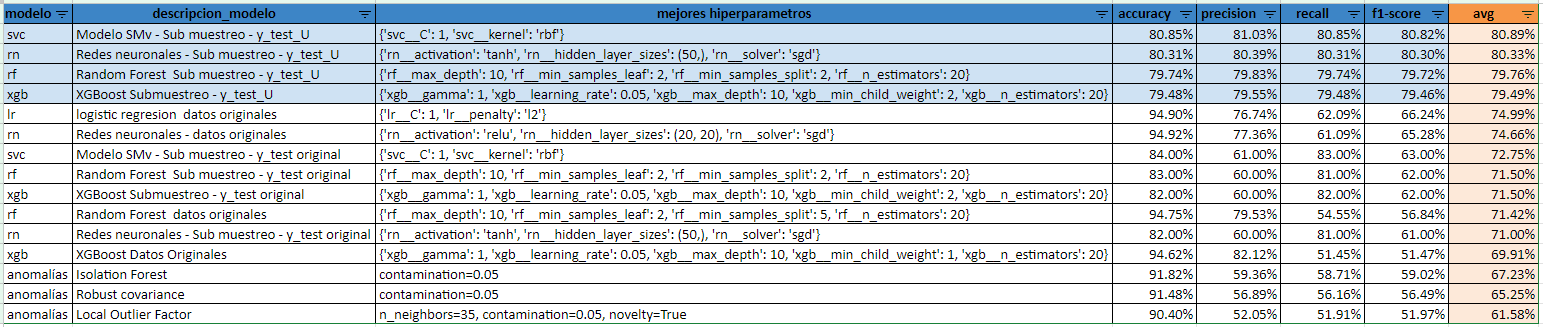

Establecimos una métrica que consiste en el promedio del accuracy, precision, recall y f1-score, y en base a ella armamos un ranking de los mejores modelos con los mejores hiperparámetros. De esta manera evidenciamos que el mejor modelo es el SVM entrenado con datos sub-muestreados.

Ahora bien, para este mejor modelo las métricas accuracy, precision, recall y f1-score fueron calculadas con los datos test también submuestreados (y_test_U), por lo que no se identifica igualdad de condiciones para comparar vs el resto de los modelos, por lo que hicimos la predicción con los datos test originales, teniendo otros resultados para los mismos modelos (los que tienen sub-fijo "submuestreo - y_test_originales").

Asumiendo de que no están en igualdad de condiciones, y revisando con los datos originales, el mejor modelo es la regresión logística.

## **4. Aplicación del modelo**
---

Una vez que haya entrenado y evaluado su modelo, es importante considerar cómo puede ser utilizado en un entorno práctico.

Intente analizar la capacidad del modelo para generalizar nuevos datos que no formaron parte del conjunto de entrenamiento o evaluación.

Como el mejor modelo es la regresión logística, usamos "grid_search_LogisticRegression" para evaluación con los datos test

In [ ]:
# Predecir en el conjunto de prueba
y_pred = grid_search_LogisticRegression.predict(X_test)

# Mostrar métricas de evaluación
print("Informe de clasificación:")
Ligistic_regression_report=classification_report(y_test, y_pred)
print(Ligistic_regression_report)

Informe de clasificación:
              precision    recall  f1-score   support

          No       0.96      0.99      0.97     46513
         Yes       0.58      0.25      0.35      2692

    accuracy                           0.95     49205
   macro avg       0.77      0.62      0.66     49205
weighted avg       0.94      0.95      0.94     49205



In [ ]:
def list_confusion_matrix(cm,classes):
  df = pd.DataFrame(data = cm,
                    index = pd.MultiIndex.from_product([['Valor real'], classes]),
                    columns = pd.MultiIndex.from_product([['Valor predicho'], classes]))

  return df

In [ ]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
class_names = ['No', 'Yes']
list_confusion_matrix(cnf_matrix,class_names)

Valor predicho     
                           No  Yes
Valor real No           46014  499
           Yes           2012  680

A pesar de que es el mejor modelo de los que probamos, en la práctica no es un buen modelo para predecir los verdaderos positivos ya que con la ayuda de la matriz de confusión evidenciamos que tenemos varios "Falsos-Negativos", por lo que para un trabajo posterior se proyecta explorar nuevas técnicas que permitan mejorar los modelos como: PCA, expandir el rango de hiperparámetros, probar con modelos alternativos, etc.

## **Créditos**
---

* **Profesor:** [Fabio Augusto Gonzalez](https://dis.unal.edu.co/~fgonza/)
* **Asistente docente :**
  * [Rosa Alejandra Superlano Esquibel](https://www.linkedin.com/in/alejandrasuperlano/).
* **Diseño de imágenes:**
    - [Rosa Alejandra Superlano Esquibel](https://www.linkedin.com/in/alejandrasuperlano/).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*